In [80]:
import matplotlib.pyplot as plt
import cv2
import skimage
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from skimage.metrics import structural_similarity as ssim

plt.rcParams.update({'font.size': 12})

## Отображение картинки

In [40]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

## Загрузка изображения

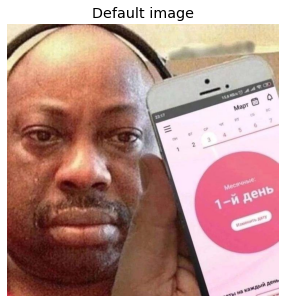

In [41]:
img = cv2.imread('./Data/2023-04-18 18.24.19.jpg')
draw_picture(img, 'Default image')

## 1. К-means

In [42]:
clusters_inertia = []
clusters = [2, 5, 10, 20]

img_reshape = img.reshape(-1, 3)
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster).fit(img_reshape)
    clusters_inertia.append(kmeans.inertia_)

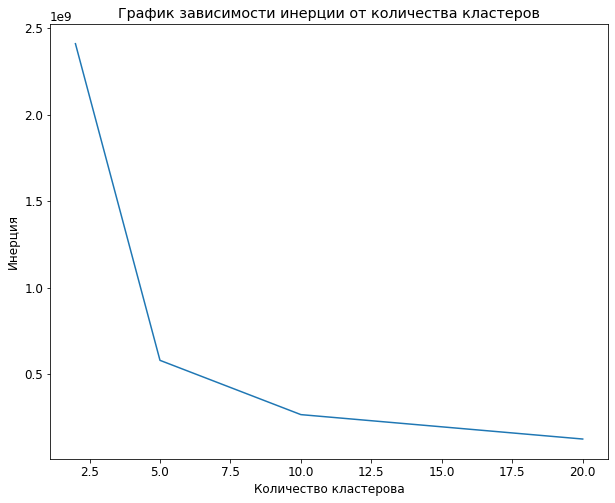

In [43]:
plt.figure(figsize=(10, 8))
plt.plot(clusters, clusters_inertia)
plt.title('График зависимости инерции от количества кластеров')
plt.xlabel('Количество кластерова')
plt.ylabel('Инерция')
plt.show()

> Из этого графика мы можем увидеть, что оптимальное число кластеров = 10.

In [44]:
kmeans = KMeans(n_clusters=10).fit(img_reshape)

centers = kmeans.cluster_centers_
labels = kmeans.labels_

segmented_image = centers[labels]
segmented_image = np.array(segmented_image.reshape(img.shape), np.uint8)

### Метрика SSIM

In [45]:
kmeans_ssim = ssim(img, segmented_image, win_size=3)
print(ssim(img, segmented_image, win_size=3))

0.8903861684069552


### 1.2 Отрисовка картинки

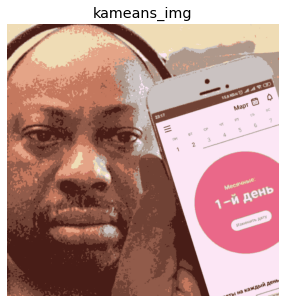

In [46]:
draw_picture(segmented_image, 'kameans_img')

> Как мы видим некоторые цвета "обобщились" в один.

## 2. DBSCAN

In [47]:
img_reshaped = img.reshape(-1, 3)

db_scan = DBSCAN(eps=1, min_samples=3).fit(img_reshaped)
img_segmented = img_reshaped[db_scan.labels_]
img_segmented = img_segmented.reshape(img.shape)

### Метрика SSIM

In [48]:
dbscan_ssim = ssim(img, img_segmented, win_size=3)
print(ssim(img, img_segmented, win_size=3))

0.2702717315511692


### 2.1 Отрисовка картинки

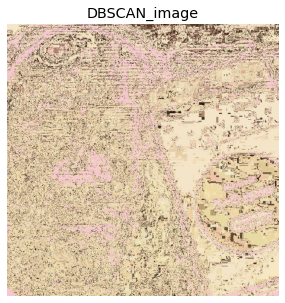

In [49]:
draw_picture(img_segmented, 'DBSCAN_image')

> Из картинки можно понять, что алгоритм плохо справляется с задачей. Так как в нем нельзя задать определенное число кластеров, а подбирать параметр eps довольно сложно

## 3. AgglomerativeClustering

In [75]:
img_resized = cv2.resize(img, (128, 128))
img_reshape = img_resized.reshape(-1, 3)
agg_cluster = AgglomerativeClustering().fit(img_reshape)

In [76]:
img_segmented = img_reshape[agg_cluster.labels_]

In [77]:
img_segmented = img_segmented.reshape(img_resized.shape)

### 3.1 Метрика SSIM

In [78]:
agglomerative_clustering = ssim(img_resized, img_segmented, win_size=3)
print(ssim(img_resized, img_segmented, win_size=3))

0.3604189770785858


### 3.2 Вывод изображения

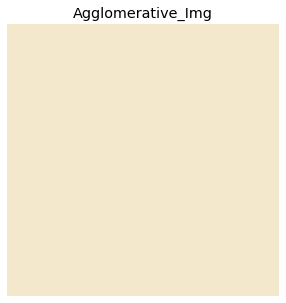

In [79]:
draw_picture(img_segmented, 'Agglomerative_Img')

## Вывод

In [83]:
pd.DataFrame(data=[
    ['kmeans', kmeans_ssim],
    ['dbsan', dbscan_ssim],
    ['AggClustering', agglomerative_clustering]
], columns=['Модель', 'SSIM'])

,Модель,SSIM
0,kmeans,0.890386
1,dbsan,0.270272
2,AggClustering,0.360419


> Из таблицы мы модем сделать вывод, что модель kmeans справилась лучше всех с кластеризацией цветов